# K-Means Clustering Implementation

**K-Means Clustering** is an unsupervised machine learning algorithm that groups data points into k clusters based on their similiarity using Euclidean distance.

## Step 1: Importing Libraries

- **NumPy**: for numerical operations (such as Euclidiean distance)
- **MatplotLib**: for plotting data and results

In [7]:
import numpy as np
import matplotlib.pyplot as plt

## Step 2: Loading data from data.txt

Each line contains two spaced-seperated floating-point values (x,y coordinates) which is a 2 feature data set

In [8]:
#Function to load data from data.txt file

def load_data(filename):
    """
    Load 2D data points from a text file.
    Each line should contain two space-separated floating-point values.
    """
    data = []
    with open(filename, 'r') as f:
        for line in f:
            #strip() removes whitespace from the beginning and end of the line
            #split() splits the line into a list of strings based on whitespace between the values
            parts = line.strip().split()
            if len(parts) >= 2: #only evaluate lines with at least 2 values
                x, y = float(parts[0]), float(parts[1]) #convert the string values to floats
                data.append([x, y]) #append the float values as a list to the data list
    return np.array(data) #convert the list of lists to a numpy array

#Load the data
X = load_data('data.txt')
print(f"Loaded {X.shape[0]} data points with {X.shape[1]} features")
print(f'Data shape: {X.shape}')
print(f'\nFirst 5 data points:')
print(X[:5]) #matches the first 5 data points in the data.txt file
    

Loaded 5000 data points with 2 features
Data shape: (5000, 2)

First 5 data points:
[[ 0.009519 -0.636513]
 [ 0.977144 -0.823159]
 [-0.001936  0.65852 ]
 [ 0.626724 -0.770501]
 [-0.694547 -0.028682]]


## Step 3: Plotting the Raw Dataset

Visualizing the dataset to understand the distribution of the data

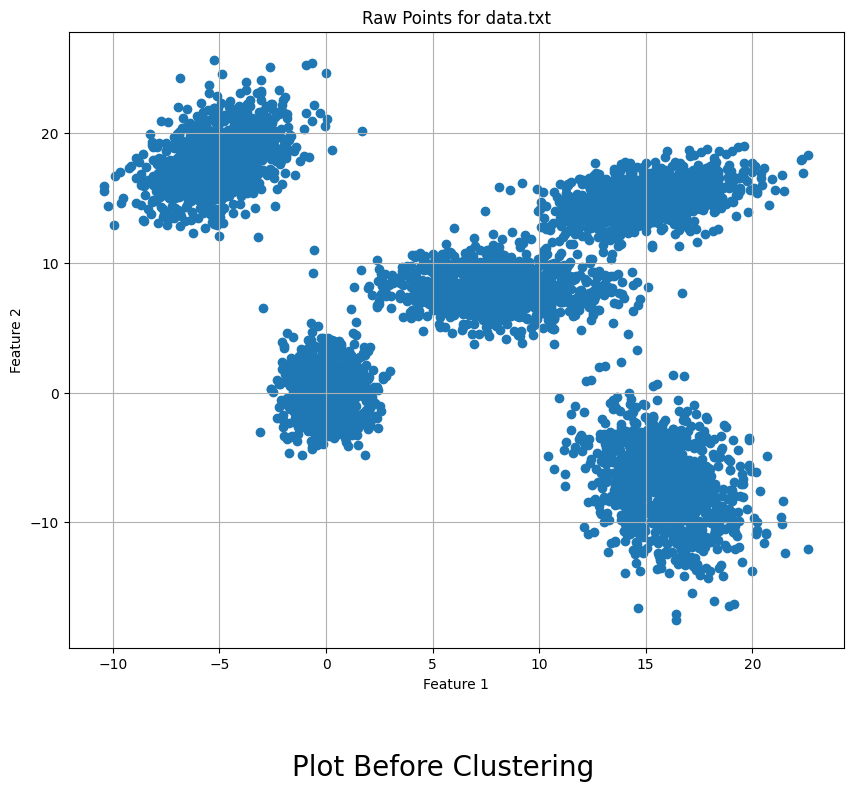

In [23]:
fig = plt.figure(figsize=(10,8)) #create a figure with a size of 10x8 inches
plt.grid(True) #add a grid to the plot
plt.scatter(X[:,0], X[:,1]) #plot the data points with a transparency of 0.6 and a size of 20
plt.title("Raw Points for data.txt")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.figtext(0.5, -0.05, "Plot Before Clustering", ha="center", fontsize=20)
plt.show()

